In [1]:
import numpy as np
from primitives.linalg import invert_covariance
from primitives.parameters import ParameterInterface

from scipy.linalg import cholesky

import pandas as pd
import matplotlib.pyplot as plt

\begin{equation}
    dX(t) = A X(t) dt + h dW(t)
\end{equation}

\begin{equation}
    X(t) = e^{A(t-s)} X(s) + \int_{s}^{t} e^{A(t-u)} h dW(u)
\end{equation}


\begin{align}
    I(t) &=  \int_{s}^{t} e^{A(t-u)} h dW(u) \\
         &\approx \sum_{i : V_i \in (s,t]} e^{A (t - V_i)} h dW_i
\end{align}


\begin{equation}
    Y(t) = H X(t) + \varepsilon(t)
\end{equation}

In [2]:
# Alternatively this class may be called (parameterised) LinearOperator.
class TransitionMatrix(ParameterInterface):
    parameter_keys = ["shape"]

    def compute_matrix(self, dt):
        pass

    def __call__(self, dt=None):
        return self.compute_matrix(dt=dt)

class LangevinTransitionMatrix(TransitionMatrix):
    parameter_keys = ["shape", "theta"]

    def compute_drift_matrix(self, dt=None):
        return np.array([[0, 1],[0, self.theta]])

    def compute_matrix(self, dt):
        expA = np.zeros(self.shape)
        expA[0][0] = 1.
        expA[0][1] = (np.exp(self.theta*dt) - 1) / self.theta
        expA[1][1] = np.exp(self.theta*dt)
        return expA

class ConstantVelocityTransitionMatrix(TransitionMatrix):
    parameter_keys = ["shape"]

    def compute_drift_matrix(self, dt=None):
        return np.array([[0, 1],[0, 0]])

    def compute_matrix(self, dt):
        expA = np.zeros(self.shape)
        expA[0][0] = 1.
        expA[0][1] = dt
        expA[1][1] = 1.
        return expA
    
class AutoRegressiveTransitionMatrix(TransitionMatrix):
    parameter_keys = ["shape", "theta"]

    def compute_matrix(self, dt):
        A = np.zeros(self.shape)
        A[0] = self.theta
        A[1:, 0:self.shape[0]-1] = np.eye(self.shape[0]-1)
        return A

class SimpleFunction(TransitionMatrix):
    parameter_keys = ["shape", "indicator_dim", "value"]

    def compute_matrix(self, dt=None):
        h = np.zeros(self.shape)
        h[self.indicator_dim[0]][self.indicator_dim[1]] = self.value
        return h

In [3]:
class ForcingTerm(ParameterInterface):
    parameter_keys = None

    def sample(self, s=None, t=None, func=None):
        pass

    def __call__(self, s=None, t=None, func=None):
        return self.sample(s=s, t=t, func=func)
    
class BrownianMotion(ForcingTerm):
    parameter_keys = ["shape"]

    def sample(self, s=None, t=None, func=None):
        dW = np.random.randn(self.shape[0], self.shape[1])
        return func(t-s) @ dW
    
class Noise(ParameterInterface):
    parameter_keys = None

    def sample(self, t=None):
        pass

    def __call__(self, t=None):
        return self.sample(t=t)
    
class GaussianNoise(Noise):
    parameter_keys = ["shape"]

    def sample(self, t=None):
        return np.random.randn(self.shape[0], self.shape[1])

In [4]:
class BaseStateSpaceModel:

    def __init__(self, system_noise, measurement_noise):
        # Set driving stochastic processes
        self.system_noise = system_noise
        self.measurement_noise = measurement_noise

        # Transition matrix
        self.A = None

        # System noise matrix
        self.h = None        

        # Measurement matrix
        self.H = None

        # Measurement noise matrix
        self.C = None

    def get_parameter_values(self):
        pass
    
    def set_parameter_values(self, **kwargs):
        pass

    def sample(self, times, size=1):
        # Initialise state and measurement arrays:
        ## The number of columns in x_init should be configurable.
        ## We assume that X starts with [0 ... 0]^T
        x_init = np.zeros((self.A.shape[1], 1))

        ## The third dimension of this array has to be same as the number of columns in x_init.
        x = np.zeros(shape=(times.shape[0], x_init.shape[0], 1))

        ## The number of columns in y should be configurable.
        y = np.zeros(shape=(times.shape[0], self.H.shape[0], 1))

        x[0] = x_init
        y[0] = self.H @ x[0] + self.C @ self.measurement_noise(t=times[0])

        for i in range(1, times.shape[0]):
            dt = times[i] - times[i-1]

            x[i] = self.A(dt) @ x[i-1] + self.system_noise(s=times[i-1], t=times[i], func=self.h)
            y[i] = self.H @ x[i-1] + self.C @ self.measurement_noise(t=times[i])

        return x, y

## Sampling points:

In [5]:
T = np.linspace(0, 100, num=500).reshape(-1, 1)

## Constant Velocity Model:

In [6]:
system_noise = BrownianMotion(**{"shape":(1,1)})
measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [7]:
drift_parameters = {"shape":(2,2)}
system_matrix = ConstantVelocityTransitionMatrix(**drift_parameters)

system_noise_parameters = {"shape":(2,1), "indicator_dim":(1,0), "value":1.}
h = SimpleFunction(**system_noise_parameters)

system_noise_matrix = h

In [8]:
model.A = system_matrix
model.h = system_noise_matrix

In [9]:
H = np.zeros((1,2))
H[0][0] = 1

model.H = H

In [10]:
C = np.array([1])[np.newaxis]
model.C = C

In [11]:
x, y = model.sample(T)

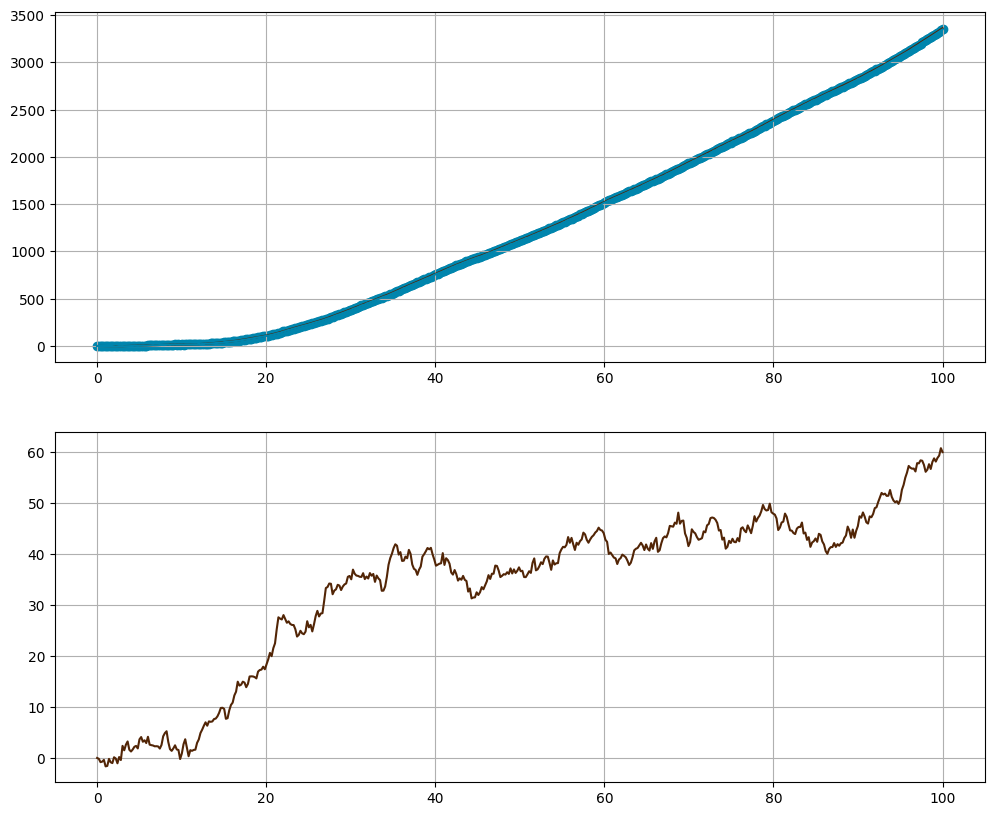

In [12]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

##   Langevin Model:

In [13]:
system_noise = BrownianMotion(**{"shape":(1,1)})
measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [14]:
drift_parameters = {"shape":(2,2), "theta":-2.}
system_matrix = LangevinTransitionMatrix(**drift_parameters)

system_noise_parameters = {"shape":(2,1), "indicator_dim":(1,0), "value":1.}
h = SimpleFunction(**system_noise_parameters)

system_noise_matrix = lambda u: system_matrix(u) @ h(u)

In [15]:
model.A = system_matrix
model.h = system_noise_matrix

In [16]:
H = np.zeros((1,2))
H[0][0] = 1

model.H = H

In [17]:
C = np.array([1])[np.newaxis]
model.C = C

In [18]:
x, y = model.sample(T)

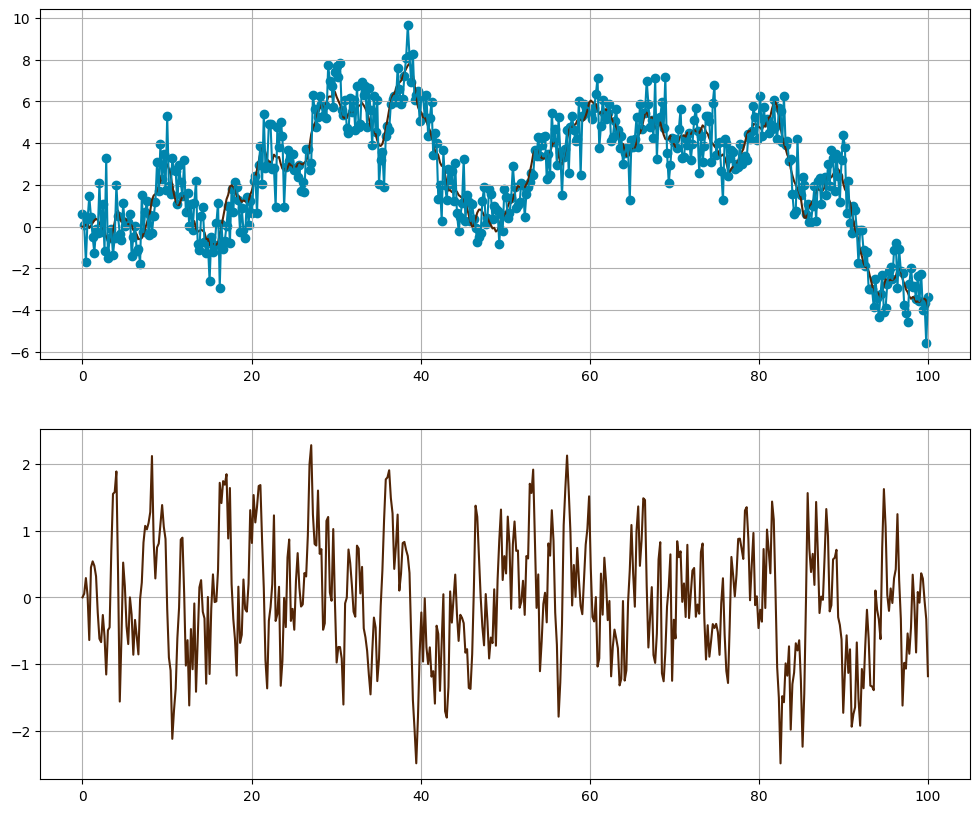

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

## Autoregressive Model:

In [21]:
system_noise = BrownianMotion(**{"shape":(1,1)})
measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [22]:
drift_parameters = {"shape":(2,2), "theta":np.array([0.8, 0.15])}
system_matrix = AutoRegressiveTransitionMatrix(**drift_parameters)

system_noise_parameters = {"shape":(2,1), "indicator_dim":(0,0), "value":1.}
h = SimpleFunction(**system_noise_parameters)

system_noise_matrix = lambda u: system_matrix(u) @ h(u)

In [23]:
model.A = system_matrix
model.h = system_noise_matrix

In [24]:
H = np.zeros((1,2))
H[0][0] = 1

model.H = H

In [25]:
C = np.array([1])[np.newaxis]
model.C = C

In [26]:
x, y = model.sample(T)

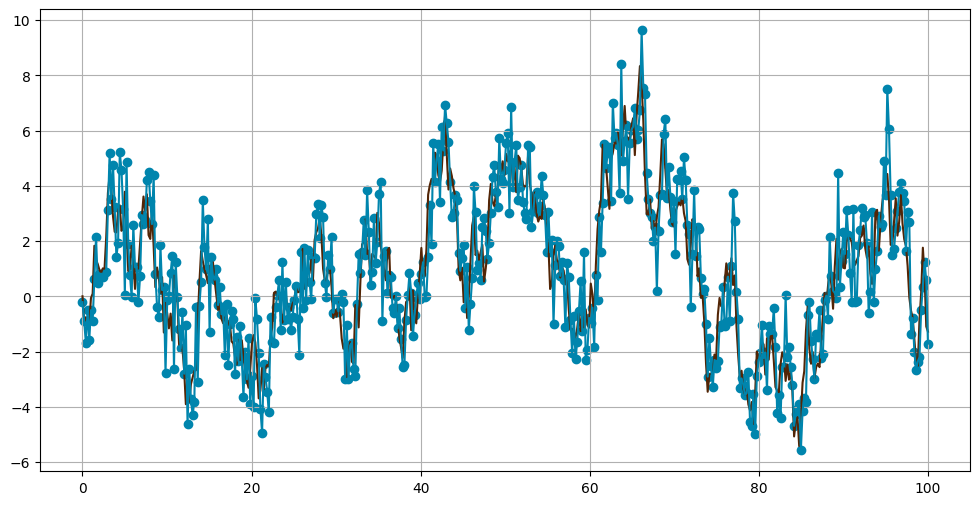

In [29]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(T, x[:,0,:], color="#522506")
ax.scatter(T, y[:,0,:], color="#0085ad")
ax.plot(T, y[:,0,:], color="#0085ad")
ax.grid(True)

plt.show()

In [2]:
class BrownianMotion(ParameterInterface):
    parameter_keys = ["dims", "cov"]
        
    def __len__(self):
        return 1
    
    def sample(self, size):
        return np.random.multivariate_normal(mean=np.zeros(self.dims), cov=self.cov, size=size).T
    

In [3]:
class StateSpaceModel:

    def __init__(self, system_noise, measurement_noise):
        # Set driving stochastic processes
        self.system_noise = system_noise
        self.measurement_noise = measurement_noise

        # The transition and observation matrices are fixed or parameterised modules.
        self.A = None
        self.H = None

    def sample(self, X, size=1):

        x_init = np.zeros((self.A.shape[0], 1))

        x = np.zeros(shape=(X.shape[0], x_init.shape[0], 1))
        y = np.zeros(shape=(X.shape[0], self.H.shape[0], 1))
        x[0] = x_init
        y[0] = self.H @ x[0] + self.measurement_noise.sample(size=1)

        for i in range(1, X.shape[0]):
            x[i] = self.A @ x[i-1] + self.system_noise.sample(size=1)
            y[i] = self.H @ x[i-1] + self.measurement_noise.sample(size=1)

        return x, y

class AutoRegressiveModel(StateSpaceModel):

    def __init__(self, p, system_noise, measurement_noise, theta=None):
        super().__init__(system_noise, measurement_noise)

        if theta is None:
            self.theta = np.random.dirichlet(alpha=np.ones(p))

        self.A = self.construct_transition_matrix(p, theta)

        H = np.zeros((1,p))
        H[0][0] = 1
        self.H = H

    def construct_transition_matrix(self, p, theta):
        # Construct autoregressive transition matrix:
        A = np.zeros((p, p))
        A[0] = theta
        A[1:, 0:p-1] = np.eye(p-1)
        return A



In [46]:
# Autoregressive model:
N = 100

D = 2
delta = 0.1

theta = np.exp(-np.arange(1, D+1)*delta)
A = np.zeros((D, D))
A[0] = theta
A[1:, 0:D-1] = np.eye(D-1)

h = np.zeros(D).reshape(-1, 1)
h[0] = 1

Q = np.zeros((D,D))
Q[0][0] = 1
R = np.array([1])[np.newaxis]

H = np.zeros((1,D))
H[0][0] = 1

In [5]:
theta = np.exp(-np.arange(1, D+1)*delta)

In [6]:
theta

array([0.90483742])

In [7]:
system_noise = BrownianMotion(**{"dims":Q.shape[0], "cov":Q})
measurement_noise = BrownianMotion(**{"dims":R.shape[0], "cov":R})

model = AutoRegressiveModel(p=D, system_noise=system_noise, measurement_noise=measurement_noise, theta=theta)

In [8]:
t = np.arange(N).reshape(-1, 1)

In [9]:
x, y = model.sample(t)

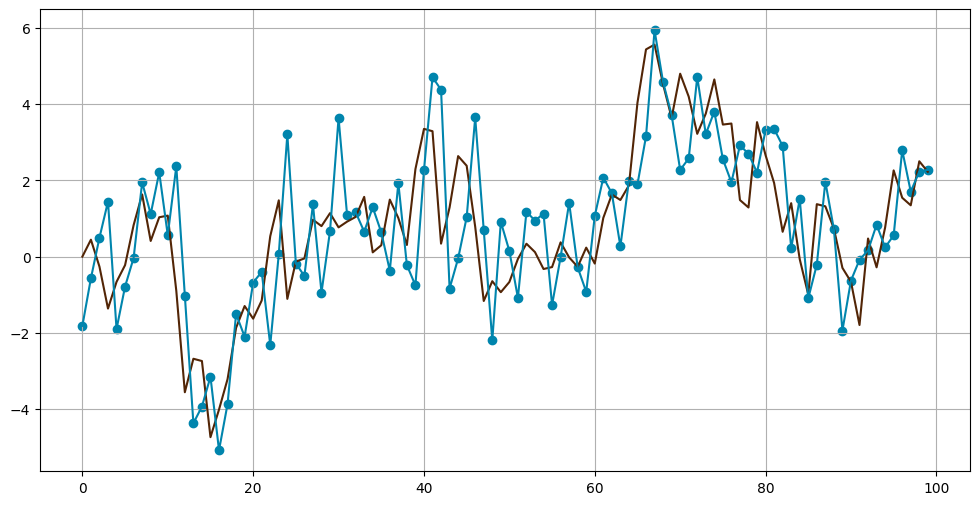

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(t, x[:,0,:], color="#522506")
ax.scatter(t, y[:,0,:], color="#0085ad")
ax.plot(t, y[:,0,:], color="#0085ad")
ax.grid(True)

plt.show()

In [11]:
# Kalman filter:

x_init = np.random.normal(loc=0., scale=1., size=(D, 1))

P_init = np.random.normal(loc=0., scale=1., size=(D, D))
P_init = np.matmul(P_init.T, P_init)

# Initialise estimate
x_est = np.zeros(shape=(N+1, x_init.shape[0], 1))
x_pred = np.zeros(shape=(N, x_init.shape[0], 1))

P_est = np.zeros(shape=(N+1, P_init.shape[0], P_init.shape[1]))
P_pred = np.zeros(shape=(N, P_init.shape[0], P_init.shape[1]))

x_est[0] = x_init
P_est[0] = P_init


In [12]:
for i in range(1, y.shape[0]+1):
    # Predict:
    x_pred[i-1] = A @ x_est[i-1]
    P_pred[i-1] = A @ P_est[i-1] @ A.T + Q

    # Update:
    residual_pred = y[i-1] - H @ x_pred[i-1]
    residual_pred_cov = H @ P_pred[i-1] @ H.T + R
    kalman_gain = P_pred[i-1] @ H.T @ invert_covariance(residual_pred_cov)

    x_est[i] = x_pred[i-1] + kalman_gain @ residual_pred
    P_est[i] = (np.eye(D) - kalman_gain @ H) @ P_pred[i-1]

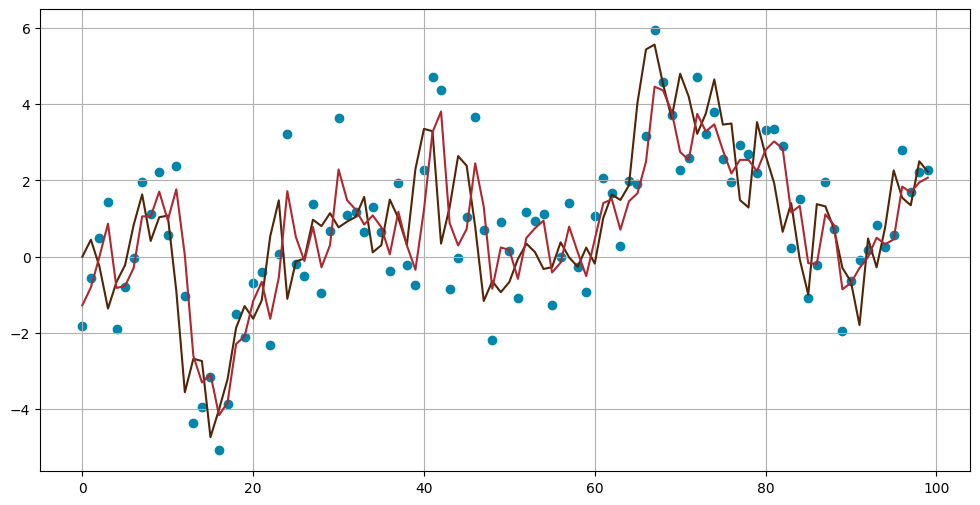

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(t, x[:,0,:], color="#522506")
ax.scatter(t, y[:,0,:], color="#0085ad")
#ax.plot(t, y[:,0,:], color="#0085ad")

ax.plot(t, x_est[1:,0,:], color="#AF272F")
ax.grid(True)

plt.show()